In [2]:
import numpy as np
import matplotlib

# Embed fonts into PDF/PS files
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.colors

import scipy.integrate
import scipy.optimize

# Progress bars
import tqdm.notebook

# Make deep copies
import copy

In [3]:
matplotlib.rcParams.update({'font.size': 7, 'axes.linewidth': 0.5, 'xtick.major.width': 0.5, 'xtick.minor.width': 0.5, 
                            'ytick.major.width': 0.5,'ytick.minor.width': 0.5, 'xtick.major.pad':2,'ytick.major.pad':2})
matplotlib.rcParams.update({'font.family':'sans-serif','font.sans-serif':['Arial']})

In [4]:
def make_rgb_transparent(rgb, bg_rgb, alpha):
    return [alpha * c1 + (1 - alpha) * c2
            for (c1, c2) in zip(rgb, bg_rgb)]

# Define parameters

In [5]:
## Physiological parameters

# mvn head sensitvity in the light: 0.38 sp/s / deg/s for ~0.85 gain -- Beraneck & Cullen 2007
# => k_eye ~= 2.2

# initial gain ~- 0.4 in mice (Katoh et al. 2015, Boyden & Raymond 2003)
# => v_0 = 1.3
v_0 = 1.3

# Eye movement response to optogenetic stimulation (Payne et al. 2019)
# ~0.1 deg/s / sp/s = k_eye * w_PC => w_PC ~= 0.05

# memory retention ~75% after 24 hr calculated from Boyden & Raymond 2003

params = {
    'mf_0': 55, # Lasker et al. 2008
    'pf_0': 14, # Arenz et al. 2008 -- assume each MF EPSC evokes a GC spike
    'cf_0': 1,
    'mf_sensitivity': 0.14, # Lasker et al. 2008
    'k_pf_h': 0.42, # Arenz et al. 2008 (See above)
    'k_pf_e': 0.42,
    'w_inh_h': 5, 
    'w_pc_mvn': 0.05, #0.5
    'k_eye': 2.2,
    'k_v': 3.9e-3, # 0.01 # to get 75% retention
    'tau_f': 0.017, # fast average
    'tau_mvn': 0.7, # 0.7 # tau_f,v: average of activity being integrated at MVN
    'k_LTD': 0.75, # for ~30% learning for 30 mins of training
    'beta_rs': 1, # Guo et al. 2014
    'w_eye': 8.43, # for eye sensitivity of 2.7 sp/s/(deg/s), Katoh et al. 2015, given PF sensitivity above
    'w_inh_e': 2,
    'k_inh': 0.01,#0.0025
}
params['k_LTP'] = params['k_LTD']*params['cf_0'] # so dw_H^+/dt = 0 when no information about errors

## Behavioral parameters

# Kimpo et al. 2014, Nguyen-Vu et al. 2013, Boyden & Raymond 2003
stim_freq = 1 
peak_velocity_learn = 15 # deg/s
peak_velocity_post = 15

# Define function for head velocity
head_learn = lambda t: peak_velocity_learn*np.sin(2*np.pi*stim_freq*3600*t)
head_post_input = lambda t: peak_velocity_post*np.sin(2*np.pi*stim_freq*3600*t) # w/post-training input
head_post_no_input = lambda t: 0 # w/o post-training input

# Define function for visual target signal
target_learn = lambda t: np.sin(2*np.pi*stim_freq*3600*t)
target_post = lambda t: 0

In [6]:
# Function to determine initial value of w_H given an initial gain value
w_e_tilde = params['k_pf_e']*(params['w_eye']-params['w_inh_e'])
w_h_0 = lambda g_init: g_init * w_e_tilde/params['k_pf_h']

# Initial gain
g_init = 0.4

In [7]:
v_0_ = lambda w_h_0: w_h_0*params['k_pf_h']/(params['k_eye']*w_e_tilde*params['mf_sensitivity'])

In [8]:
gain = lambda w_h, v: params['k_eye']*((params['mf_sensitivity']*v - 
                                    params['k_pf_h']*params['w_pc_mvn']*(w_h)) / 
                                    (1 - params['w_pc_mvn']*params['k_pf_e']*params['k_eye']*(params['w_eye']-params['w_inh_e'])))
    

## ODE Solver
We model the evolution of the state `y`, which has eight components: `y[0]` is $w_H^+$, `y[1]` is $v$, `y[2]` is $\langle\text{MF}(\text{PC}-\theta)\rangle$, `y[3]` is $\langle\text{PF}_H\rangle$, `y[4]` is $\langle\text{PF}_H\cdot\text{CF}\rangle$, `y[5]` is $\theta= \langle\text{PC}\rangle$, `y[6]` is $w_H^-$ and `y[7]` is $\langle\text{PF}_H(\text{PC}-\theta)\rangle$. The evolution is defined in Materials and Methods, _Circuit model with internal feedback loop_.

In [9]:
# Function to pass to ODE solver
def feedback2D_Inh(t, y, head, target_gain, learn, params):
    '''
    head: a function taking a time argument that returns the head velocity
    target_gain: scalar value of target input-to-output gain
    learn: set to True if in the training period, False if in the post-training period
    params: list containing the physiological parameters
    
    '''
    w_h_exc = y[0]
    w_h_inh = y[6]
    w_h = w_h_exc - w_h_inh
    w_e = params['w_eye']-params['w_inh_e']
    
    v = y[1]
    theta = y[5]
    
    current_gain = params['k_eye']*((params['mf_sensitivity']*v - 
                                    params['k_pf_h']*params['w_pc_mvn']*(w_h)) / 
                                    (1 - params['w_pc_mvn']*params['k_pf_e']*params['k_eye']*w_e))
    eye = -current_gain * head(t)
    
    delta_mf = params['mf_sensitivity']*head(t)
    delta_pf_h = params['k_pf_h']*head(t)
    delta_pf_e = params['k_pf_e']*eye
    
    
    mf = params['mf_0'] + delta_mf
    pf_h = params['pf_0'] + delta_pf_h
    pf_e = params['pf_0'] + delta_pf_e
    
    pc = params['pc_0'] + w_h*pf_h + w_e*pf_e
    
    rs = -(target_gain - current_gain)*head(t)
    
    delta_cf = np.tanh(-params['beta_rs']*rs*learn)
    cf = params['cf_0'] + delta_cf
    
    dydt = np.zeros(8)
    # w_H^+, v, <MF(PC-<PC>)>, <PF_H>, <PF_H*CF>, <PC>, w_H^-, <PF(PC - <PC>)>
    dydt[0] = params['k_LTP']*y[3] - params['k_LTD']*y[4]
    dydt[1] = params['k_v']*(-y[2])
    dydt[2] = 1/params['tau_mvn'] * (-y[2] + mf*(pc - theta))
    dydt[3] = 1/params['tau_f'] * (-y[3] + pf_h)
    dydt[4] = 1/params['tau_f'] * (-y[4] + pf_h*cf)
    dydt[5] = 1/params['tau_f'] * (-y[5] + pc)
    dydt[6] = params['k_inh']*y[7]
    dydt[7] = 1/params['tau_f'] * (-y[7] + pf_h*(pc - theta))
    
    return dydt

# Jacobian 
def feedback2D_Inh_Jac(t, y, head, target_gain, learn, params):
    w_h_exc = y[0]
    w_h_inh = y[6]
    w_h = w_h_exc - w_h_inh
    w_e = params['w_eye']-params['w_inh_e']
    
    v = y[1]
    theta = y[5]
    
    w_e_ = params['k_eye']*params['k_pf_e']*w_e
    d = 1 - params['w_pc_mvn']*w_e_
    
    current_gain = params['k_eye']*((params['mf_sensitivity']*v - 
                                    params['k_pf_h']*params['w_pc_mvn']*(w_h)) / d)
    eye = -current_gain * head(t)
    
    delta_mf = params['mf_sensitivity']*head(t)
    delta_pf_h = params['k_pf_h']*head(t)
    delta_pf_e = params['k_pf_e']*eye
    
    mf = params['mf_0'] + delta_mf
    pf_h = params['pf_0'] + delta_pf_h
    # pf_e = params['pf_0'] + delta_pf_e
    
    # pc = params['pc_0'] + w_h*pf_h + w_e*pf_e
    
    rs = -(target_gain - current_gain)*head(t)
    
    delta_cf = np.tanh(-params['beta_rs']*rs*learn)
    
    dpc_dwh = params['pf_0'] + params['k_pf_h']/d*head(t)
    dpc_dv = - w_e_*params['mf_sensitivity']/d*head(t)
    
    dg_dwh = -params['k_eye']*params['w_pc_mvn']*params['k_pf_h']/d
    dg_dv = params['k_eye']*params['mf_sensitivity']/d
    
    K = (1 - delta_cf**2)*pf_h
    
    jac = np.zeros((8,8))
    jac[0,:] = np.array([0, 0, 0, params['k_LTP'], -params['k_LTD'], 0, 0, 0])
    jac[1, 2] = -params['k_v']
    jac[2,:] = 1/params['tau_mvn']*np.array([mf*dpc_dwh, mf*dpc_dv, -1, 0,0,-mf,0,0])
    jac[3,3] = -1/params['tau_f']
    jac[4,:] = 1/params['tau_f']*np.array([-K*params['beta_rs']*learn*dg_dwh*head(t),
                                            -K*params['beta_rs']*learn*dg_dv*head(t),  
                                             0, 0, -1, 0, 0, 0])
    
    jac[5,:] = 1/params['tau_f']*np.array([dpc_dwh, dpc_dv, 0, 0, 0, -1, 0, 0])
    jac[6,7] = params['k_inh']
    jac[7,:] = 1/params['tau_f']*np.array([pf_h*dpc_dwh, pf_h*dpc_dv, 0, 0,0,-pf_h,0,-1])
    
    return jac

In [10]:
# Value of w_H for a starting gain of 0.4
w_h_0(g_init)

2.5719999999999996

In [11]:
w_h_0_ = 2.5

For simplicity of plotting, we set the initial value of $w_H$ to 2.5, which leads to an initial value of $v$:

In [12]:
v_0 = v_0_(w_h_0_)
print(v_0)

1.262345741350407


and starting gain:

In [13]:
gain(w_h_0_, v_0_(w_h_0_))

0.3888024883359254

In [14]:
# Spontaneous firing rate of PCs ~50 sp/s (Katoh et al. 2015) 
# and MVNs is ~57 sp/s (Nelson et al. 2003)

# Calculate PC and MVN offsets so that this is the firing rate at baseline
params['pc_0'] = 50 - params['pf_0']*(w_h_0_ + params['w_eye']-params['w_inh_e'])
params['mvn_0'] = 57 - params['mf_0']*v_0_(w_h_0_) + params['w_pc_mvn']*50

In [15]:
# Correction factors for spontaneous firing rates
params['pc_0'], params['mvn_0']

(-75.02, -9.929015774272372)

In [16]:
g_des = 2 # Target gain value during training

## Initial conditions
theta_0 = params['pc_0'] + params['pf_0']*(w_h_0_ + params['w_eye']-params['w_inh_e'])

# w_H^+, v, <MF(PC-<PC>)>, <PF_H>, <PF_H*CF>, <PC>, w_H^-, <PF(PC - <PC>)>
y_0 = np.array([w_h_0_ + params['w_inh_h'], v_0, 0, params['pf_0'], params['pf_0']*params['cf_0'], theta_0, params['w_inh_h'], 0])

# Figure 6, bottom row

## Run simulation

In [18]:
T_learn = 0.5 # h

T_post = 24 # s

## Time steps for plotting (ODE solver uses variable time steps)

dt_learn = 1/3600 # h (= 1 s)
dt_post = 10*60/3600 # h (= 10 min)

t_learn = np.linspace(0, T_learn, int(T_learn/dt_learn))
t_post = np.linspace(0, T_post-T_learn, int(T_post/dt_post)) + T_learn


# Solution during the training period
sol_learn = scipy.integrate.solve_ivp(lambda t,y: feedback2D_Inh(t,y, head_learn, g_des, True, params), [0, T_learn], y_0, 
                                  jac=lambda t,y: feedback2D_Inh_Jac(t,y,head_learn, g_des,True,params), method='Radau', dense_output=True, max_step=0.25/3600)

y_learn = sol_learn.sol(t_learn)

sol_recov = scipy.integrate.solve_ivp(lambda t,y: feedback2D_Inh(t,y, head_post_input, g_des, False, params), [T_learn, T_post], y_learn[:,-1], 
                                  jac=lambda t,y: feedback2D_Inh_Jac(t,y,head_post_input,
                                                             g_des,False,params), method='Radau', dense_output=True, max_step=0.25/3600)

y_recov = sol_recov.sol(t_post)

In [19]:
t_ = np.concatenate((t_learn, t_post))
y_ = np.hstack((y_learn, y_recov))

## Figure 6B

In [20]:
w_H = y_[0,:] - y_[6,:]

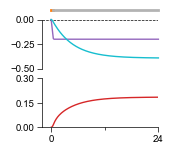

In [21]:
plt.figure(figsize=(1.5,1.4))

ax = plt.subplot(2,1,1)

plt.plot([-2,24], [0,0],'k--',lw=0.5)

plt.plot([0, 0.5],[0.1,]*2,  c='C1', lw=2, clip_on=False)
plt.plot([0.5, 24], [0.1,]*2,  c=(0.7,)*3, lw=2, clip_on=False)

plt.plot(t_, (y_[0,:]-y_[0,0])/y_[0,0], c='C4', clip_on=False,lw=1)
plt.plot(t_, (y_[6,:]-y_[6,0])/y_[6,0], c='C9', clip_on=False,lw=1)
plt.ylim([-0.5, 0])
plt.xlim([-2,24])
ax.xaxis.set_visible(False)

ax.set_yticks([0, -0.25, -0.5])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax = plt.subplot(2,1,2)
plt.plot(t_, (y_[1,:]-y_[1,0])/y_[1,0], c='C3',lw=1)

plt.ylim([0, 0.3])
plt.xlim([-2,24])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticks([0, 0.15,0.3])

ax.set_xticks([0,12,24])
ax.set_xticks([0, 24])
ax.set_xticks([12], minor=True)

## Figure 6C, D
For the bottom panel, we plot the time course of the circuit's input-output gain.

In [22]:
gain_ = gain(w_H, y_[1,:])
gain_v = y_[1,:]*params['mf_sensitivity']*params['k_eye'] # gain(w_H[0], y_[1,:])

Calculate percentage gain change that is consolidated:

In [23]:
gain_learn = gain(y_learn[0,:]-y_learn[6,:],y_learn[1,:])
gain_post = gain(y_recov[0,:]-y_recov[6,:],y_recov[1,:])

In [24]:
(gain_post[-1]-gain_learn[0])/(gain_learn[-1]-gain_learn[0])

0.753638761642356

For the top panel, we calculate the change in sensitivity of PCs to the sensory (vestibular) input, relative to a sliding average, and mulitply by peak velocity to get the change in the amplitude of PC modulation.

In [25]:
w_H = y_[0,:] - y_[6,:]
w_E = params['w_eye'] - params['w_inh_e']
v = y_[1,:]



delta_pc_amp = ((params['k_pf_h']*w_H - params['k_eye']*params['k_pf_e']*w_E*params['mf_sensitivity']*v)/
            (1 - params['w_pc_mvn']*params['k_eye']*params['k_pf_e']*w_E))
pc_avg = params['pc_0'] + params['pf_0']*(w_H + w_E)

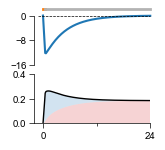

In [26]:
plt.figure(figsize=(1.5,1.4))

ax = plt.subplot(2,1,1)

plt.plot(t_, delta_pc_amp*peak_velocity_post,clip_on=False)
plt.plot([-1,24], [0,0],c='k',ls='--',lw=0.5, clip_on=False)

plt.plot([0, T_learn], [2,]*2, c='C1', lw=2, clip_on=False)
plt.plot([T_learn, T_post], [2,]*2, c=(0.7,)*3, lw=2, clip_on=False)
# plt.ylim()
plt.ylim([-15, 0])
plt.xlim([-2,24])
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.xaxis.set_visible(False)

plt.yticks([0, -8, -16])

ax = plt.subplot(2,1,2)
plt.fill_between(t_, np.zeros(len(t_)), gain_v/gain_v[0]-1, facecolor='C3',alpha=0.2)
plt.fill_between(t_, gain_v/gain_v[0]-1,gain_/gain_[0]-1,  facecolor='C0',alpha=0.2 )
plt.plot(t_, gain_/gain_[0]-1, c='k',lw=1)

# plt.plot([0, 0.5],[0.4,]*2,  c='C1', lw=2, clip_on=False)
# plt.plot([0.5, 24], [0.4,]*2,  c=(0.7,)*3, lw=2, clip_on=False)


plt.ylim([0, 0.4])
plt.xlim([-2,24])
ax=plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks([0, 24])
ax.set_xticks([12], minor=True)
ax.set_xticklabels([0, 24])

plt.savefig('figures/figure 6/pc-gain-inh-new-model.pdf')

## Figure 6E
Here we plot the phase portrait of the weight dynamics of the circuit, as well as the continuum of steady states.

In [99]:
sigma_h2 = 0.5*peak_velocity_post**2


w_e_tilde = params['k_pf_e']*(params['w_eye']-params['w_inh_e'])

delta_pc_sens = lambda w_h, v: ((params['k_pf_h']*(w_h) - 
                              params['k_eye']*w_e_tilde*
                                 params['mf_sensitivity']*v)/
                              (1 - params['w_pc_mvn']*params['k_eye']*w_e_tilde))

attractor_slope = params['k_pf_h']/(params['k_eye']*w_e_tilde*params['mf_sensitivity'])


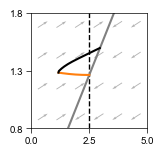

In [28]:
plt.figure(figsize=(1.5,1.5))

# Plot attractor
xlims = [0, 5] 
ylims = [0.8, 1.8]

plt.plot([w_H[0],]*2,ylims,'k--', lw=1) # starting point


# w_max = (params['mf_sensitivity']*ylims[1] - gain_phase_learn_incomplete[-1]/params['k_eye'])/(params['w_pc_mvn']*params['pf_sensitivity'])


w_max = ylims[1]/attractor_slope

plt.plot([xlims[0], w_max], (np.array([xlims[0], w_max])*attractor_slope),
        c=(0.5, 0.5, 0.5))

plt.plot(y_learn[0,:]-y_learn[6,:], y_learn[1,:], c='C1')
plt.plot(y_recov[0,:]-y_recov[6,:], y_recov[1,:], c='k')

ylimrange = ylims[1]-ylims[0]
xlimrange = xlims[1]-xlims[0]

plt.ylim(ylims)
plt.xlim(xlims)

ww_phase, vv_phase = np.meshgrid(xlims[0] + np.linspace(0.1,0.9,6)*xlimrange,ylims[0] + np.linspace(0.1,0.9,4)*ylimrange)

dw_phase = -params['k_inh']*params['k_pf_h']*delta_pc_sens(ww_phase,vv_phase)*sigma_h2
dv_phase = -params['k_v']*(params['mf_sensitivity']*delta_pc_sens(ww_phase,vv_phase)*sigma_h2)

dw_phase_norm = dw_phase/np.sqrt(dw_phase**2+dv_phase**2)
dv_phase_norm = dv_phase/np.sqrt(dw_phase**2+dv_phase**2)

plt.quiver(ww_phase, vv_phase, dw_phase_norm, dv_phase_norm, pivot='middle', scale=10, angles='xy', color=(0.7, 0.7, 0.7, 1))



ax = plt.gca()
ax.set_xticks([0, 2.5, 5])
ax.set_yticks([0.8, 1.3, 1.8]);
plt.savefig('figures/figure 6/phase-inh-new-model.pdf')

# Phase plots during training (Fig. S4A)

In [198]:
# approximate condition for trajectories to stay in region w^*_{H,opt} < w_H < w^*_{H,dark}
(params['k_v']*params['mf_sensitivity']**2/(params['k_inh']*params['k_pf_h']**2), 
 params['w_pc_mvn'])

(0.04333333333333334, 0.05)

In [140]:
dt_long = 60/3600
T_learn_long = 48
t_sol_online = np.arange(0, int(T_learn_long/dt_long))*dt_long

sol_online = scipy.integrate.solve_ivp(lambda t,y: feedback2D_Inh(t,y, head_learn, g_des, True, params), [0, T_learn_long], y_0, 
                                  jac=lambda t,y: feedback2D_Inh_Jac(t,y,head_learn, g_des,True,params), method='Radau', dense_output=True, max_step=0.25/3600)


In [141]:
y_online = sol_online.sol(t_sol_online)
gain_online = gain(y_online[0,:]-y_online[6,:], y_online[1,:])

In [149]:
w_H_online = y_online[0,:]-y_online[6,:]

In [150]:
attractor_slope = params['k_pf_h']/(params['k_eye']*w_e_tilde*params['mf_sensitivity'])

w_e_tilde = params['k_pf_e']*(params['w_eye']-params['w_inh_e'])
wh_opt_line = lambda wh, g_t: 1/params['mf_sensitivity']*(params['w_pc_mvn']*params['k_pf_h']*wh 
                               + g_t/params['k_eye']*(1-params['w_pc_mvn']*params['k_eye']*w_e_tilde))

k_l = params['k_LTD']*params['beta_rs']*params['k_eye']*params['w_pc_mvn']
alpha = k_l/(k_l + params['k_inh'])

In [170]:
sigma_h2 = 0.5*peak_velocity_learn**2
delta_pc_sens = lambda w_h, v: ((params['k_pf_h']*(w_h) - 
                              params['k_eye']*w_e_tilde*
                                 params['mf_sensitivity']*v)/
                              (1 - params['w_pc_mvn']*params['k_eye']*w_e_tilde))

In [172]:
T_avg = 0.5/3600 # one half cycle at 1 Hz
avg_equation = lambda t,w,v: head_learn(t)*np.tanh(-params['beta_rs']*(g_des - gain(w,v))*head_learn(t))
dwhedt_approx = lambda w,v: 1/T_avg*params['k_LTD']*params['k_pf_h']*scipy.integrate.quad(lambda t: avg_equation(t,w,v), 0, T_avg)[0]

dwhedt_approx_vec = np.vectorize(dwhedt_approx)

In [188]:
dwhidt = lambda w,v: -params['k_inh']*params['k_pf_h']*delta_pc_sens(w,v)*sigma_h2

def wh_star_line(w_h, g_des):
    init_guess = alpha*wh_opt_line(w_h, g_des) + (1-alpha)*attractor_slope*w_h
    sol = scipy.optimize.root_scalar(lambda v: dwhedt_approx(w_h, v) + dwhidt(w_h, v), x0=init_guess, bracket=[-6, 18])
    return sol.root

wh_star_line_vec = np.vectorize(wh_star_line)

In [174]:
w_opt = w_h_0(g_des)

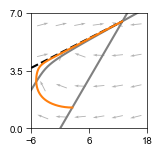

In [194]:
plt.figure(figsize=(1.5,1.5))
xlims = [-6, 18]
ylims = [0, 7]
w_max = xlims[-1]# ylims[1]/attractor_slope

ylimrange = ylims[1]-ylims[0]
xlimrange = xlims[1]-xlims[0]
ww_phase, vv_phase = np.meshgrid(xlims[0] + np.linspace(0.1,0.9,6)*xlimrange,ylims[0] + np.linspace(0.1,0.9,4)*ylimrange)

dw_phase = -params['k_inh']*params['k_pf_h']*delta_pc_sens(ww_phase,vv_phase)*sigma_h2 + dwhedt_approx_vec(ww_phase,vv_phase)
dv_phase = -params['k_v']*(params['mf_sensitivity']*delta_pc_sens(ww_phase,vv_phase)*sigma_h2)

dw_phase_norm = dw_phase/np.sqrt(dw_phase**2+dv_phase**2)
dv_phase_norm = dv_phase/np.sqrt(dw_phase**2+dv_phase**2)

plt.quiver(ww_phase, vv_phase, dw_phase_norm, dv_phase_norm, pivot='middle', scale=10, angles='xy', color=(0.7, 0.7, 0.7, 1))

plt.plot([xlims[0], w_max], (np.array([xlims[0], w_max])*attractor_slope),
        c=(0.5, 0.5, 0.5))

w_star_line = np.linspace(xlims[0], w_max)
plt.plot(w_star_line, wh_star_line_vec(w_star_line, g_des),
        c=(0.5, 0.5, 0.5))

plt.plot([xlims[0], w_opt], wh_opt_line(np.array([xlims[0], w_opt]),g_des),
        c='k', ls='--')

plt.plot(w_H_online,y_online[1,:], c='C1')
plt.xlim(xlims)
plt.ylim(ylims)

plt.xticks([-6, 6, 18])
plt.yticks([0, 3.5, 7])

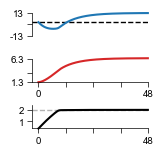

In [214]:
plt.figure(figsize=(1.5,1.5))
ax = plt.subplot(3,1,1)
plt.plot([-3, 48],[y_online[0,0]-y_online[6,0]]*2,'k--',lw=1)
# plt.plot(sol_learn.t, sol_learn.y[0,:]-params['w_i'],c='C0',clip_on=False)
plt.plot(t_sol_online, y_online[0,:]-y_online[6,:],c='C0',clip_on=False)

plt.yticks([-13, 0,13], [-13,  '', 13])
plt.ylim([-13, 13])
plt.xlim([-3, 48])


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.xticks([])


ax = plt.subplot(3,1,2)

plt.plot(t_sol_online, y_online[1,:],c='C3',clip_on=False)
plt.ylim([v_0,6.3])
plt.xlim([-3, 48])
plt.yticks([1.3,3.3,6.3],[1.3,'',6.3])
plt.xticks([0, 12,24,36,48],[0, '','', '',48])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax = plt.subplot(3,1,3)
plt.plot([-3,48],[2,2],'--',lw=1, c=(0.7,)*3, clip_on=False)
plt.plot(t_sol_online, gain_online,c='k',clip_on=False)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlim([-3,48])
plt.ylim([0.4, 2.4])
plt.xticks([0,12,24,36,48],[0, '', '', '',48]);
# plt.yticks([0.4, 0.7,1],[0.4, '', 1]);

plt.subplots_adjust(hspace=1)